# Notebook reviewing CHIRPS-GEFS and IMERG around cyclone landfall

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [12]:
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path
import rasterio
from datetime import datetime
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import re
from src.constants import *
from src.datasources import codab, imerg

In [3]:
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
total_bbox = gdf_adm1.total_bounds

In [4]:
landfall_df = pd.read_csv(
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed.csv"
)
date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)

In [5]:
drive_folder = Path(AA_DATA_DIR_NEW) / "public" / "raw" / "moz" / "chirps-gefs"
output_folder = "ds-aa-moz-cyclones/raw/chirps-gefs"
STORAGE_ACCOUNT_NAME = "imb0chd0dev"
CONTAINER_NAME = "projects"
SAS_TOKEN = os.getenv("DSCI_AZ_BLOB_DEV_SAS")

In [26]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days_before = 5
extra_days_after = 3
dfs = []
for name, row in landfall_df.set_index("NAME").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days_before)
    end_date = landfall_date + pd.Timedelta(days=extra_days_after)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(
        gdf_adm1["ADM1_PCODE"], start_date, end_date
    )
    df_in["NAME"] = name
    dfs.append(df_in)

imerg_df = pd.concat(dfs, ignore_index=True)

In [27]:
imerg_df

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std,NAME
0,MOZ,MZ01,2007-02-17,1,14.532315,10.2250,0.0,102.015030,2567,37304.453,14.965138,FAVIO
1,MOZ,MZ01,2007-02-18,1,5.100855,1.1250,0.0,47.800000,2567,13093.895,7.972108,FAVIO
2,MOZ,MZ01,2007-02-19,1,0.621362,0.0200,0.0,15.884998,2567,1595.035,1.735594,FAVIO
3,MOZ,MZ01,2007-02-20,1,9.109441,4.9300,0.0,119.149994,2567,23383.934,13.645438,FAVIO
4,MOZ,MZ01,2007-02-21,1,0.336350,0.0450,0.0,6.795000,2567,863.410,0.699122,FAVIO
...,...,...,...,...,...,...,...,...,...,...,...,...
2074,MOZ,MZ11,2024-03-11,1,6.263532,1.1100,0.0,113.134995,3460,21671.820,12.329615,FILIPO
2075,MOZ,MZ11,2024-03-12,1,4.774464,1.9325,0.0,42.820000,3460,16519.645,6.716722,FILIPO
2076,MOZ,MZ11,2024-03-13,1,2.756480,1.3750,0.0,66.550000,3460,9537.420,4.482171,FILIPO
2077,MOZ,MZ11,2024-03-14,1,1.610724,0.0000,0.0,34.495000,3460,5573.105,3.871162,FILIPO


In [28]:
storms = [
    storm
    for storm in os.listdir(drive_folder)
    if os.path.isdir(drive_folder / storm)
]

In [29]:
output_drive_folder = (
    Path(AA_DATA_DIR_NEW) / "public" / "processed" / "moz" / "chirps-gefs"
)
df = pd.read_csv(
    output_drive_folder / "chirps_gefs_storm_rainfall_forecast.csv"
)

In [30]:
df

,min,max,mean,median,percentile_10,percentile_25,percentile_75,percentile_90,ADM1_PT,ADM1_PCODE,storm,release_date,forecast_date,leadtime,days_around_landfall_release,days_around_landfall_forecast
0,2.666953,23.110664,8.616564,7.432296,4.810526,5.936393,9.759614,15.375449,Cabo Delgado,MZ01,FAVIO,2007-02-17,2007-02-23,6,-5,1
1,1.882760,13.682445,6.856328,6.826742,4.493655,5.520406,8.159672,9.148391,Gaza,MZ02,FAVIO,2007-02-17,2007-02-23,6,-5,1
2,1.953866,19.771961,6.934037,5.755760,3.925403,4.541694,8.377123,12.248544,Inhambane,MZ03,FAVIO,2007-02-17,2007-02-23,6,-5,1
3,4.826375,38.401936,18.874340,18.880661,11.243801,13.792780,22.868195,27.029818,Manica,MZ04,FAVIO,2007-02-17,2007-02-23,6,-5,1
4,0.000000,6.682936,1.320434,0.629700,0.232363,0.333623,2.046637,3.717987,Maputo,MZ05,FAVIO,2007-02-17,2007-02-23,6,-5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8146,0.000000,5.011128,1.811390,1.876618,0.000000,0.769524,2.786188,3.447981,Nampula,MZ07,FILIPO,2024-03-12,2024-03-15,3,0,3
8147,0.000000,12.662124,3.795303,3.469069,1.103859,2.159233,5.361537,6.986392,Niassa,MZ08,FILIPO,2024-03-12,2024-03-15,3,0,3
8148,0.000000,26.131596,7.457258,6.595007,1.717784,3.993495,10.542794,14.216588,Sofala,MZ09,FILIPO,2024-03-12,2024-03-15,3,0,3
8149,0.000000,20.082561,3.559964,3.440701,0.863442,1.853759,4.727351,5.947574,Tete,MZ10,FILIPO,2024-03-12,2024-03-15,3,0,3


Distribution of rainfall by lead time

In [31]:
# merging these
df["forecast_date"] = pd.to_datetime(df["forecast_date"])
imerg_df["valid_date"] = pd.to_datetime(imerg_df["valid_date"])

merged_df = df.merge(
    imerg_df,
    left_on=["ADM1_PCODE", "forecast_date", "storm"],
    right_on=["pcode", "valid_date", "NAME"],
)
merged_df.columns

Index(['min_x', 'max_x', 'mean_x', 'median_x', 'percentile_10',
       'percentile_25', 'percentile_75', 'percentile_90', 'ADM1_PT',
       'ADM1_PCODE', 'storm', 'release_date', 'forecast_date', 'leadtime',
       'days_around_landfall_release', 'days_around_landfall_forecast', 'iso3',
       'pcode', 'valid_date', 'adm_level', 'mean_y', 'median_y', 'min_y',
       'max_y', 'count', 'sum', 'std', 'NAME'],
      dtype='object')

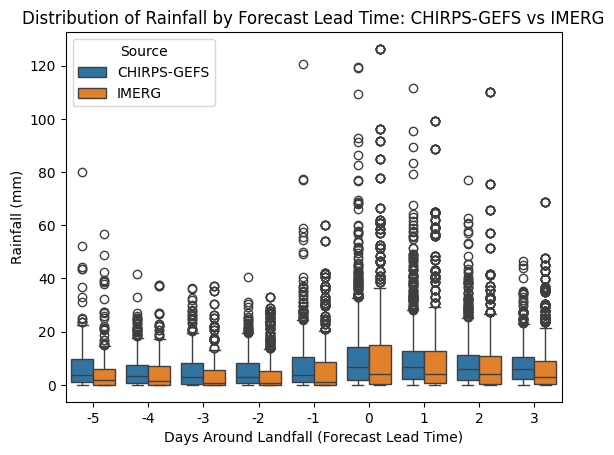

In [ ]:
# Distribution of Rainfall by lead time
plot_df = merged_df.melt(
    id_vars=["days_around_landfall_forecast"],
    value_vars=["mean_x", "mean_y"],
    var_name="Source",
    value_name="Rainfall",
)

plot_df["Source"] = plot_df["Source"].map(
    {"mean_x": "CHIRPS-GEFS", "mean_y": "IMERG"}
)

sns.boxplot(
    data=plot_df, x="days_around_landfall_forecast", y="Rainfall", hue="Source"
)
plt.title(
    "Distribution of Rainfall by Forecast Lead Time: CHIRPS-GEFS vs IMERG"
)
plt.xlabel("Days Around Landfall (Forecast Lead Time)")
plt.ylabel("Rainfall (mm)")
plt.show()

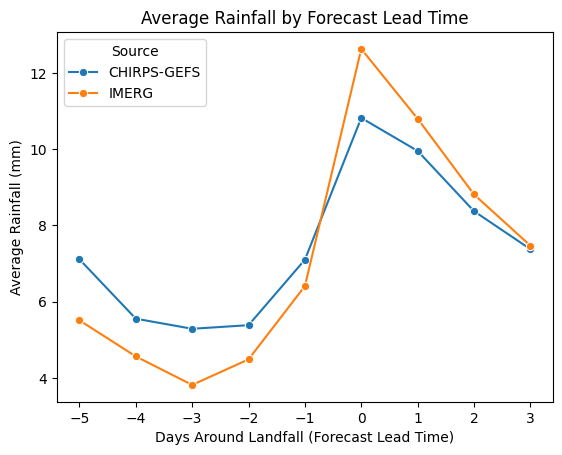

In [ ]:
avg_df = (
    merged_df.groupby("days_around_landfall_forecast")[["mean_x", "mean_y"]]
    .mean()
    .reset_index()
)

avg_df = avg_df.rename(columns={"mean_x": "CHIRPS-GEFS", "mean_y": "IMERG"})

plot_df = avg_df.melt(
    id_vars="days_around_landfall_forecast",
    var_name="Source",
    value_name="Rainfall",
)

sns.lineplot(
    data=plot_df,
    x="days_around_landfall_forecast",
    y="Rainfall",
    hue="Source",
    marker="o",
)
plt.title("Average Rainfall by Forecast Lead Time")
plt.xlabel("Days Around Landfall (Forecast Lead Time)")
plt.ylabel("Average Rainfall (mm)")
plt.show()

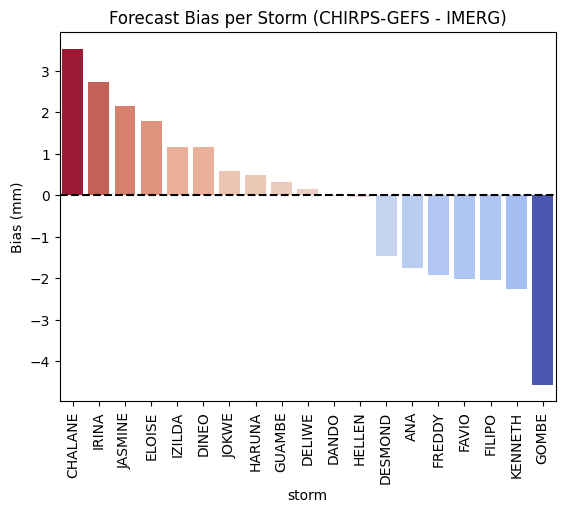

In [44]:
# Forecast bias by storm: Positive = overprediction, negative = underprediction
bias_df = merged_df.groupby("storm")[["mean_x", "mean_y"]].mean().reset_index()
bias_df["bias"] = bias_df["mean_x"] - bias_df["mean_y"]  # GEFS - IMERG

bias_df = bias_df.sort_values("bias", ascending=False)

sns.barplot(
    data=bias_df,
    x="storm",
    y="bias",
    hue="bias",
    palette="coolwarm",
    dodge=False,
    legend=False,
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Forecast Bias per Storm (CHIRPS-GEFS - IMERG)")
plt.ylabel("Bias (mm)")
plt.xticks(rotation=90)
plt.show()

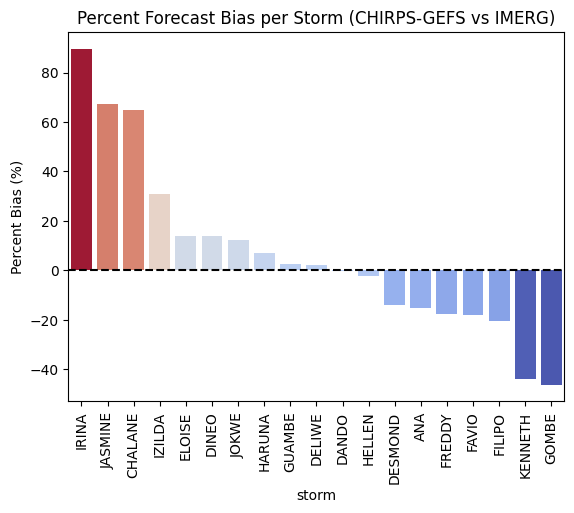

In [ ]:
# Percent bias
bias_df["percent_bias"] = (
    (bias_df["mean_x"] - bias_df["mean_y"]) / bias_df["mean_y"]
) * 100
bias_df = bias_df.sort_values("percent_bias", ascending=False)
sns.barplot(
    data=bias_df,
    x="storm",
    y="percent_bias",
    hue="percent_bias",
    palette="coolwarm",
    dodge=False,
    legend=False,
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Percent Forecast Bias per Storm (CHIRPS-GEFS vs IMERG)")
plt.ylabel("Percent Bias (%)")
plt.xticks(rotation=90)
plt.show()

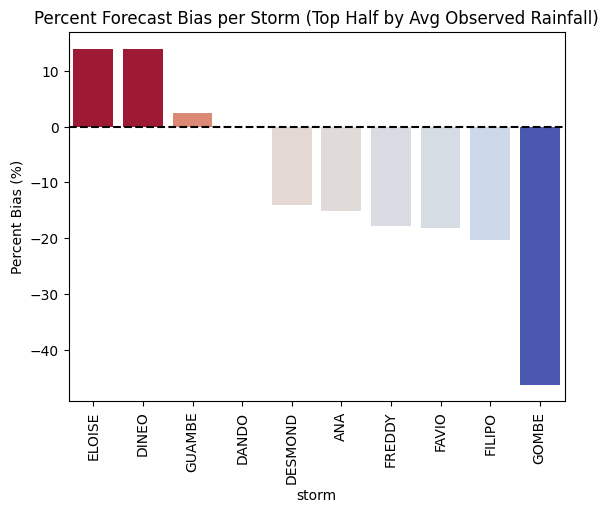

In [51]:
# For higher rainfall events
storm_avg_obs = (
    merged_df[merged_df["days_around_landfall_forecast"].isin([-1, 0, 1])]
    .groupby("storm")["mean_y"]
    .mean()
)
threshold = storm_avg_obs.quantile(0.5)
high_rain_storms = storm_avg_obs[storm_avg_obs >= threshold].index
high_rain_df = merged_df[merged_df["storm"].isin(high_rain_storms)]
bias_df = (
    high_rain_df.groupby("storm")[["mean_x", "mean_y"]].mean().reset_index()
)
bias_df["percent_bias"] = (
    (bias_df["mean_x"] - bias_df["mean_y"]) / bias_df["mean_y"]
) * 100
bias_df = bias_df.sort_values("percent_bias", ascending=False)
sns.barplot(
    data=bias_df,
    x="storm",
    y="percent_bias",
    hue="percent_bias",
    palette="coolwarm",
    dodge=False,
    legend=False,
)
plt.axhline(0, color="black", linestyle="--")
plt.title(
    "Percent Forecast Bias per Storm (Top Half by Avg Observed Rainfall)"
)
plt.ylabel("Percent Bias (%)")
plt.xticks(rotation=90)
plt.show()

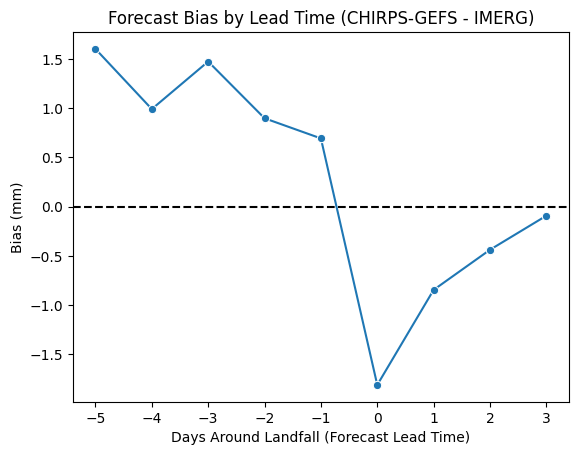

In [ ]:
lead_bias = (
    merged_df.groupby("days_around_landfall_forecast")[["mean_x", "mean_y"]]
    .mean()
    .reset_index()
)
lead_bias["bias"] = lead_bias["mean_x"] - lead_bias["mean_y"]  # GEFS - IMERG

sns.lineplot(
    data=lead_bias, x="days_around_landfall_forecast", y="bias", marker="o"
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Forecast Bias by Lead Time (CHIRPS-GEFS - IMERG)")
plt.xlabel("Days Around Landfall (Forecast Lead Time)")
plt.ylabel("Bias (mm)")
plt.show()

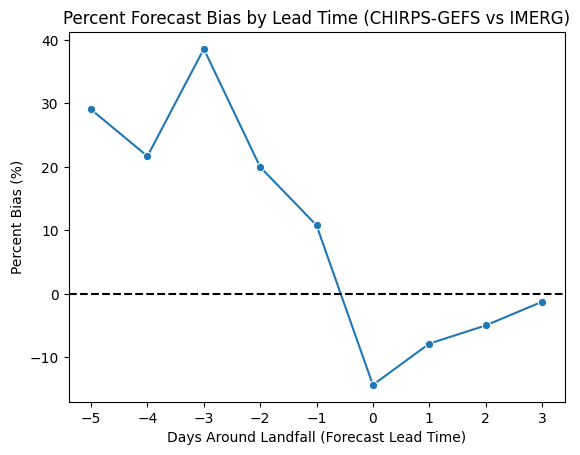

In [ ]:
lead_bias["percent_bias"] = (
    (lead_bias["mean_x"] - lead_bias["mean_y"]) / lead_bias["mean_y"]
) * 100
sns.lineplot(
    data=lead_bias,
    x="days_around_landfall_forecast",
    y="percent_bias",
    marker="o",
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Percent Forecast Bias by Lead Time (CHIRPS-GEFS vs IMERG)")
plt.xlabel("Days Around Landfall (Forecast Lead Time)")
plt.ylabel("Percent Bias (%)")
plt.show()

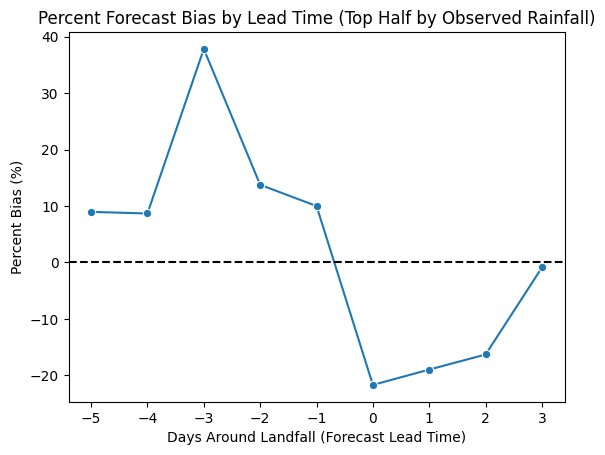

In [ ]:
# for higher rainfall events
storm_avg_obs = merged_df.groupby("storm")["mean_y"].mean()
threshold = storm_avg_obs.quantile(0.5)
high_rain_storms = storm_avg_obs[storm_avg_obs >= threshold].index
high_rain_df = merged_df[merged_df["storm"].isin(high_rain_storms)]
lead_bias = (
    high_rain_df.groupby("days_around_landfall_forecast")[["mean_x", "mean_y"]]
    .mean()
    .reset_index()
)
lead_bias["percent_bias"] = (
    (lead_bias["mean_x"] - lead_bias["mean_y"]) / lead_bias["mean_y"]
) * 100
sns.lineplot(
    data=lead_bias,
    x="days_around_landfall_forecast",
    y="percent_bias",
    marker="o",
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Percent Forecast Bias by Lead Time (Top Half by Observed Rainfall)")
plt.xlabel("Days Around Landfall (Forecast Lead Time)")
plt.ylabel("Percent Bias (%)")
plt.show()

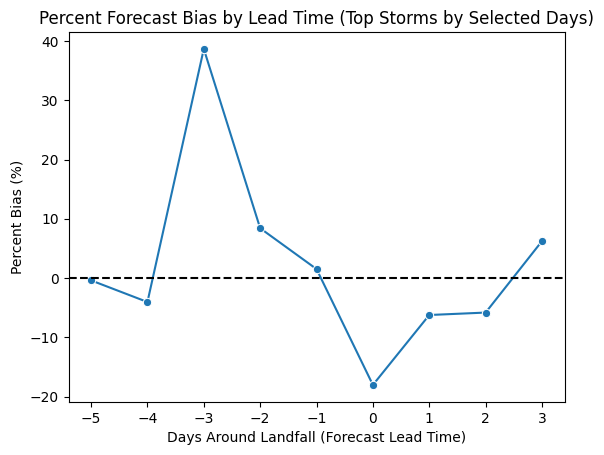

In [ ]:
selected_days = merged_df[
    merged_df["days_around_landfall_forecast"].between(-1, 1)
]
storm_avg_obs = selected_days.groupby("storm")["mean_y"].mean()
threshold = storm_avg_obs.quantile(0.67)
top_storms = storm_avg_obs[storm_avg_obs >= threshold].index
high_rain_df = merged_df[merged_df["storm"].isin(top_storms)]
lead_bias = (
    high_rain_df.groupby("days_around_landfall_forecast")[["mean_x", "mean_y"]]
    .mean()
    .reset_index()
)
lead_bias["percent_bias"] = (
    (lead_bias["mean_x"] - lead_bias["mean_y"]) / lead_bias["mean_y"]
) * 100
sns.lineplot(
    data=lead_bias,
    x="days_around_landfall_forecast",
    y="percent_bias",
    marker="o",
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Percent Forecast Bias by Lead Time (Top Storms by Selected Days)")
plt.xlabel("Days Around Landfall (Forecast Lead Time)")
plt.ylabel("Percent Bias (%)")
plt.show()

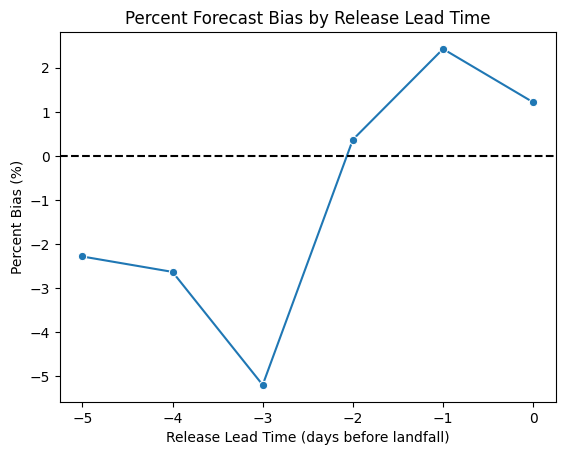

In [61]:
release_bias = (
    merged_df.groupby("days_around_landfall_release")[["mean_x", "mean_y"]]
    .mean()
    .reset_index()
)

release_bias["percent_bias"] = (
    (release_bias["mean_x"] - release_bias["mean_y"]) / release_bias["mean_y"]
) * 100

sns.lineplot(
    data=release_bias,
    x="days_around_landfall_release",
    y="percent_bias",
    marker="o",
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Percent Forecast Bias by Release Lead Time")
plt.xlabel("Release Lead Time (days before landfall)")
plt.ylabel("Percent Bias (%)")
plt.show()